In [10]:
#importing modules

import warnings 
warnings.filterwarnings('ignore')

import time
t = time.time()

print('Importing startred...')

# base libraries
import os
import numpy as np
import pandas as pd
import re
from scipy import stats
from random import randint
from datetime import datetime


# visualization libraries
import matplotlib.pyplot as plt
import matplotlib 
%matplotlib inline
import seaborn as sns
import missingno as msno
import plotly.express as px


# preprocessing libraries


from sklearn.model_selection import (TimeSeriesSplit,
                                     GridSearchCV,
                                     RandomizedSearchCV,
                                     train_test_split, 
                                     KFold, 
                                     StratifiedKFold,
                                    cross_val_score)

from sklearn.preprocessing import (LabelEncoder,
                                   StandardScaler, 
                                   MinMaxScaler, 
                                   OrdinalEncoder)

from sklearn.feature_selection import SelectFromModel


# metrics
from sklearn.metrics import (mean_squared_error, 
                             r2_score, 
                             mean_absolute_error)
from sklearn.metrics import make_scorer


# modeling algos
from sklearn.linear_model import (LogisticRegression,
                                  Lasso, 
                                  ridge_regression,
                                  LinearRegression)
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (AdaBoostRegressor, 
                              RandomForestRegressor,
                              VotingRegressor, 
                              GradientBoostingRegressor)
from xgboost import XGBRegressor
from lightgbm import (LGBMRegressor,
                      early_stopping)

from sklearn.base import clone ## sklearn base models for stacked ensemble model


#Interpretiability of the model
# import shap
# import eli5
# from eli5.sklearn import PermutationImportance


## misea
from sklearn.pipeline import make_pipeline
print('Done, All the required modules are imported. Time elapsed: {}sec'.format(time.time()-t))


Importing startred...
Done, All the required modules are imported. Time elapsed: 0.0023186206817626953sec


# Data Loading and Initila insights

In [11]:
# loading data
customer = pd.read_csv('../input/mobile-usage-time-prediction/customers.csv', delimiter = ',', encoding = 'utf-8')
pings = pd.read_csv('../input/mobile-usage-time-prediction/pings.csv', delimiter = ',', encoding = 'utf-8')
test_df = pd.read_csv('../input/mobile-usage-time-prediction/test.csv', delimiter = ',', encoding = 'utf-8')

In [12]:
customer.head()

,id,gender,age,number_of_kids
0,979863,MALE,26,2
1,780123,MALE,60,2
2,614848,MALE,45,4
3,775046,MALE,62,3
4,991601,MALE,23,0


In [13]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              2500 non-null   int64 
 1   gender          2500 non-null   object
 2   age             2500 non-null   int64 
 3   number_of_kids  2500 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 78.2+ KB


In [14]:
pings.head()

,id,timestamp
0,899313,1496278800
1,373017,1496278800
2,798984,1496278800
3,245966,1496278800
4,689783,1496278800


In [15]:
# test_d.head()

In [16]:
pings.shape

#reduicing size for data
# pings = pings.loc[:500000]

(50528701, 2)

In [17]:
print('$'*10 + ' Data Summary and Inital peaks ' + '$'*10 )

print('\n'+'$'*15 + 'Shapes of Data ' + '$'*15+'\n' )

print('Shape of the Customer database: {}'.format(customer.shape))
print('Shape of the Pings dataset: {}'.format(pings.shape))
print('Shape of the Test dataset: {}'.format(test_df.shape))

print('\n'+'*'*50 + '\n')

print(' Head of Customer database '+ '\n')
print(customer.head())

print('\n' +'*'*50+ '\n')

print('Head of Ping dataset'+ '\n')
print(pings.head())

print('\n' +'*'*50 + '\n')

print('Head of Test dataset'+ '\n')
print(test_df.head())

print('\n' +'*'*50 + '\n')

$$$$$$$$$$ Data Summary and Inital peaks $$$$$$$$$$

$$$$$$$$$$$$$$$Shapes of Data $$$$$$$$$$$$$$$

Shape of the Customer database: (2500, 4)
Shape of the Pings dataset: (50528701, 2)
Shape of the Test dataset: (17500, 3)

**************************************************

 Head of Customer database 

       id gender  age  number_of_kids
0  979863   MALE   26               2
1  780123   MALE   60               2
2  614848   MALE   45               4
3  775046   MALE   62               3
4  991601   MALE   23               0

**************************************************

Head of Ping dataset

       id   timestamp
0  899313  1496278800
1  373017  1496278800
2  798984  1496278800
3  245966  1496278800
4  689783  1496278800

**************************************************

Head of Test dataset

       id      date  online_hours
0  979863  28/06/17             7
1  979863  27/06/17             9
2  979863  26/06/17             9
3  979863  25/06/17            10
4  979863  24/06

**value sorting with respect to id and timestamp**

# EXTRACTING USEFULL INFORMATION FROM HIDDEN DATA

In [18]:
pings = pings.sort_values(by = ['id','timestamp']).reset_index(drop=True)

# creating a copy to preserve actual ping data
temp_ping_df = pings.copy()
temp_ping_df.drop_duplicates(inplace = True)
temp_ping_df['timestamp_decode'] = temp_ping_df['timestamp'].apply(lambda x: datetime.fromtimestamp(x))
temp_ping_df.head()

,id,timestamp,timestamp_decode
0,111556,1496279340,2017-06-01 01:09:00
1,111556,1496279355,2017-06-01 01:09:15
2,111556,1496279370,2017-06-01 01:09:30
3,111556,1496279400,2017-06-01 01:10:00
4,111556,1496279430,2017-06-01 01:10:30


In [78]:
## EXTRACTING DATE
temp_ping_df['date'] = temp_ping_df['timestamp_decode'].dt.date
temp_ping_df['time'] = temp_ping_df['timestamp_decode'].dt.time

temp_ping_df.head()

,id,timestamp,timestamp_decode,date,online_hours,time
0,111556,1496279340,2017-06-01 01:09:00,2017-06-01,0.033333,01:09:00
1,111556,1496279355,2017-06-01 01:09:15,2017-06-01,0.004167,01:09:15
2,111556,1496279370,2017-06-01 01:09:30,2017-06-01,0.004167,01:09:30
3,111556,1496279400,2017-06-01 01:10:00,2017-06-01,0.008333,01:10:00
4,111556,1496279430,2017-06-01 01:10:30,2017-06-01,0.008333,01:10:30


In [79]:
# EXTRACTING HOURS SPENT ONLINE
temp_ping_df['online_hours'] = (temp_ping_df.groupby(by=['id','date'])['timestamp'].diff())/(60*60)
temp_ping_df['online_hours']  =  temp_ping_df['online_hours'].apply(lambda x: x if x< (2/60) else (2/60))
temp_ping_df.head()

,id,timestamp,timestamp_decode,date,online_hours,time
0,111556,1496279340,2017-06-01 01:09:00,2017-06-01,0.033333,01:09:00
1,111556,1496279355,2017-06-01 01:09:15,2017-06-01,0.004167,01:09:15
2,111556,1496279370,2017-06-01 01:09:30,2017-06-01,0.004167,01:09:30
3,111556,1496279400,2017-06-01 01:10:00,2017-06-01,0.008333,01:10:00
4,111556,1496279430,2017-06-01 01:10:30,2017-06-01,0.008333,01:10:30


In [ ]:
temp_ping_df.fillna(0,inplace = True)
# MAKING DATA CAPABLE FOR MERGING

# **# creating our training data**

In [ ]:
train_df= (temp_ping_df.groupby(by = ['id','date'])['online_hours'].sum()).reset_index()
# IN ABOVE CODE ONES HAVING SAME "ID" & "DATE" ARE GROUPED TOGETHER AND THEIR SUM OF ONLINE OUR IS STORED

train_df['online_hours'] = round(train_df['online_hours'],1) #runding off hours
train_df.head()
print('Done, All the required modules are imported. Time elapsed: {}sec'.format(time.time()-t))

In [23]:
# # train_2 = train_df.copy()
# # train_2.index= train_2['date' ]
# train_2 = train_df.set_index(['id' ,'date'])
# # train_2 = train_df.set_index(['date'])#,'id'])

# train_2.head(10)
# # # train_2.describe()


In [24]:
colors= ['#11CBD7' ,'#C6F1E7' ,'#F0FFF3' ,'#FA4659']


In [25]:
# # fig = plt.figure(figsize = (15,6))
# # fig.set_facecolor('#f5f6f6')
# # gs = fig.add_gridspec(10,10)

# # sns.distplot(x = train_df['online_hours'],
# #              hist_kws = {'color':colors[0], 'linewidth': 2,'edgecolor':colors[-1], 'alpha':0.9 },
# #              kde = True,kde_kws = {'color':'black', "linewidth": 1.5})#, ax=ax0)
# # print('this step took: {}sec'.format(time.time()-t))
# /

In [26]:
# # train_date_order = train_df.date.sort_values()#.unique()#.tolist()
# # # print(type(train_date_order))
# # train_date_order.head()
#  .

In [27]:
# sns.countplot(x = train_df['date'],order = train_date_order,
#               color = colors[0], edgecolor = colors[2], linewidth =2,alpha = 0.8)

# installing an automatedinbuilt function for automatic visualization

In [28]:
# # installing autoviz for simple insights
# !pip install autoviz #insatlling autoviz
# !pip install xlrd
# from autoviz.AutoViz_Class import AutoViz_Class

In [29]:
# autoviz = AutoViz_Class().AutoViz('../input/mobile-usage-time-prediction/customers.csv')


In [30]:
# Okay everything ready, now lets see the min, max dates for train and test datasets Then move with concatination of both dataframes...

print('\n' +'*'*50 + '\n')
print('Minimum date and Maximum date for train dataset: {},{}'.format(train_df.date.min(), train_df.date.max()))
print('Minimum date and Maximum date for test dataset: {},{}'.format(test_df.date.min(), test_df.date.max()))
print('\n' +'*'*50 + '\n')
print('this step took: {}sec'.format(time.time()-t))


**************************************************

Minimum date and Maximum date for train dataset: 2017-06-01,2017-06-22
Minimum date and Maximum date for test dataset: 22/06/17,28/06/17

**************************************************

this step took: 431.84272742271423sec


# more work on data


In [ ]:
# MERGING THE CUSTOMER DATABASE WITH THE PINGS DATABASE
temp_df = pd.merge(left = customer, right = train_df, on = 'id', how = 'outer')

temp_df.dropna(inplace = True) # droping ROWS WITH MISSING VALUES
temp_df['gender'] = temp_df['gender'].replace({'MALE':1, 'FEMALE':0}) #TYPE CONVERSION

# CONVERTING DATE TO DATETIME TYPE
temp_df['date'] = pd.to_datetime(temp_df['date'])

## data and time related basic features
temp_df['day_name'] = temp_df['date'].dt.day_name()
temp_df['day'] = temp_df['date'].dt.day
temp_df['month'] = temp_df['date'].dt.month
temp_df['month_name'] = temp_df['date'].dt.month_name()
temp_df['year'] = temp_df['date'].dt.year
temp_df['dayofweek'] = temp_df['date'].dt.dayofweek
temp_df['week']= temp_df['date'].dt.week



week_names = {'Sunday':0,'Monday':'1','Tuesday':2,'Wednesday':3, 'Thursday':4,'Friday':5,'Saturday':6}
month_names = {'January':0, 'February':1,'March':2,'April':3,'May':4,'June':5,'July':6,
                'August':7, 'September':8,'October':9,'November':10,'December':11}

temp_df['day_name'] = temp_df['day_name'].map(week_names)
temp_df['month_name'] = temp_df['month_name'].map(month_names)

In [ ]:
temp_df.head()

In [33]:
fig = px.histogram(temp_df, x='age', y ='online_hours', color='gender', marginal='box')
fig.show()

can be easily seen that male tens to have more sreen time than than females

In [34]:
fig = px.histogram(temp_df, x='number_of_kids', y ='online_hours', color='gender', marginal='box')
fig.show()

<AxesSubplot:xlabel='day', ylabel='online_hours'>

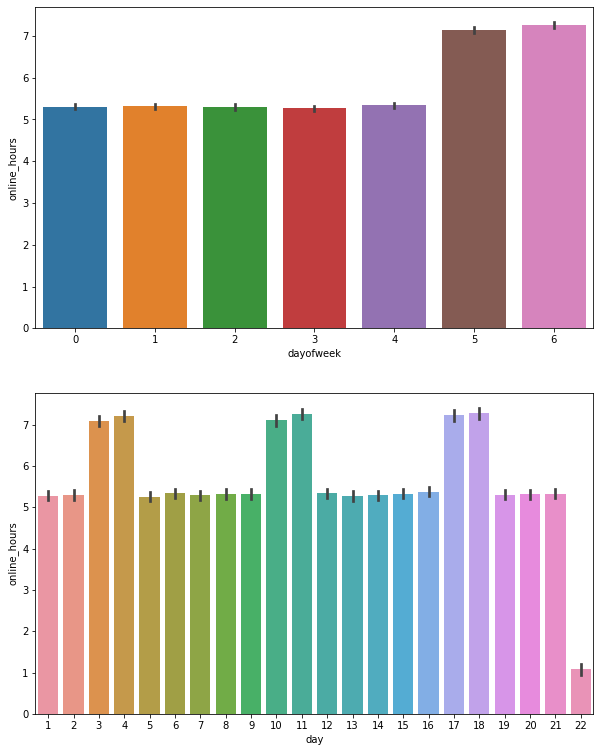

In [35]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(10, 13))
sns.barplot(temp_df["dayofweek"], temp_df["online_hours"],ax=ax0 , )
sns.barplot(temp_df["day"], temp_df["online_hours"], ax= ax1)


<AxesSubplot:xlabel='age', ylabel='online_hours'>

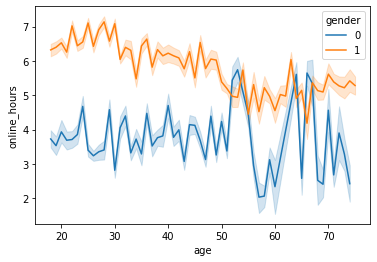

In [36]:
sns.lineplot(x='age', y='online_hours', data=temp_df, hue='gender')

In [37]:
# plt.plot(x='time', y='online_hours', data=temp_df)#, hue='gender'
# sns.stripplot(temp_df.time, temp_df.online_hours, jitter=0.25, size=8, linewidth=.5)

# GOING WITH REGULAR APPROACH OF REGRESSORS

In [38]:
### solving model like a typical regression problem without any considerations and feature engineering
X = temp_df.drop(columns = ['date','id','online_hours'])
y = temp_df['online_hours']

# train, testing data spliting
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 2021) #shuffle an02d randomized selection

In [39]:
temp_df.head()

,id,gender,age,number_of_kids,date,online_hours,day_name,day,month,month_name,year,dayofweek,week
0,979863,1,26,2,2017-06-01,8.8,4,1,6,5,2017,3,22
1,979863,1,26,2,2017-06-02,11.7,5,2,6,5,2017,4,22
2,979863,1,26,2,2017-06-03,9.9,6,3,6,5,2017,5,22
3,979863,1,26,2,2017-06-04,9.1,0,4,6,5,2017,6,22
4,979863,1,26,2,2017-06-06,11.1,2,6,6,5,2017,1,23


In [40]:
X_train.shape
X_train.head()

,gender,age,number_of_kids,day_name,day,month,month_name,year,dayofweek,week
28546,0,48,2,5,9,6,5,2017,4,23
5003,1,61,4,2,6,6,5,2017,1,23
34132,0,39,0,2,6,6,5,2017,1,23
16169,0,45,3,6,3,6,5,2017,5,22
2015,1,29,4,2,20,6,5,2017,1,25


In [41]:
# scaling
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

In [43]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

input_shape = [X_train.shape[1]]
model = keras.Sequential([
    layers.BatchNormalization(input_shape = input_shape),
    layers.Dense(20 ,activation= 'relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(8, activation = 'relu'),
    layers.Dense(10 )
])    

    
model.compile(
    loss = 'mse',
    optimizer = 'adam', 
    metrics = ['mean_squared_error']        
)

early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.01,
    restore_best_weights=True,
)
history = model.fit(
    X_train, y_train,
#     validation_data=(X2_test, y2_test),
    validation_split= 0.2,
    batch_size=512,
    epochs=50,
    callbacks=[early_stopping]
)

2022-09-19 02:21:19.303106: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
53/53 [==============================] - 2s 9ms/step - loss: 37.1096 - mean_squared_error: 37.1096 - val_loss: 37.3076 - val_mean_squared_error: 37.3076
Epoch 2/50
53/53 [==============================] - 0s 5ms/step - loss: 31.2421 - mean_squared_error: 31.2421 - val_loss: 31.3095 - val_mean_squared_error: 31.3095
Epoch 3/50
53/53 [==============================] - 0s 5ms/step - loss: 23.3133 - mean_squared_error: 23.3133 - val_loss: 20.1051 - val_mean_squared_error: 20.1051
Epoch 4/50
53/53 [==============================] - 0s 5ms/step - loss: 15.5238 - mean_squared_error: 15.5238 - val_loss: 11.2633 - val_mean_squared_error: 11.2633
Epoch 5/50
53/53 [==============================] - 0s 5ms/step - loss: 11.0425 - mean_squared_error: 11.0425 - val_loss: 8.3794 - val_mean_squared_error: 8.3794
Epoch 6/50
53/53 [==============================] - 0s 4ms/step - loss: 9.1219 - mean_squared_error: 9.1219 - val_loss: 7.3623 - val_mean_squared_error: 7.3623
Epoch 7/50
53/53 [====

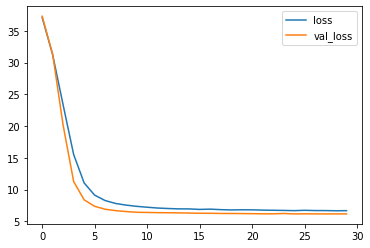

In [44]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();

In [46]:
mse, mae = model.evaluate(X_test , y_test)
print( "mean square error is :" , mse)
print( "mean abosulte error is :" , mae)


261/261 [==============================] - 0s 2ms/step - loss: 6.3686 - mean_squared_error: 6.3686
mean square error is : 6.368587493896484
mean abosulte error is : 6.368587493896484


# adding tiem series features (lag and date)

In [62]:
## preparing the training data
data2 = temp_df.copy()

data2['last_day_onlinehours'] = data2.groupby(['id'])['online_hours'].shift(1) 
data2['last_day_diff'] = data2.groupby(['id'])['last_day_onlinehours'].diff() 
# data2['day']= temp_df['date'].dt.dayofyear

X2= data2.drop(['id','date','day_name'] , axis=1)
y2 = data2['online_hours']

X2_train,X2_test,y2_train,y2_test = train_test_split(X2,y2,test_size = 0.2) #shuffle and randomized selection
X2_train.fillna(X2.median().round(1), inplace=True)


In [63]:
X2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41738 entries, 0 to 41754
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   gender                41738 non-null  int64  
 1   age                   41738 non-null  int64  
 2   number_of_kids        41738 non-null  int64  
 3   online_hours          41738 non-null  float64
 4   day                   41738 non-null  int64  
 5   month                 41738 non-null  int64  
 6   month_name            41738 non-null  int64  
 7   year                  41738 non-null  int64  
 8   dayofweek             41738 non-null  int64  
 9   week                  41738 non-null  int64  
 10  last_day_onlinehours  39258 non-null  float64
 11  last_day_diff         36778 non-null  float64
dtypes: float64(3), int64(9)
memory usage: 5.1 MB


In [64]:
X2.head()

,gender,age,number_of_kids,online_hours,day,month,month_name,year,dayofweek,week,last_day_onlinehours,last_day_diff
0,1,26,2,8.8,1,6,5,2017,3,22,NaN,NaN
1,1,26,2,11.7,2,6,5,2017,4,22,8.8,NaN
2,1,26,2,9.9,3,6,5,2017,5,22,11.7,2.9
3,1,26,2,9.1,4,6,5,2017,6,22,9.9,-1.8
4,1,26,2,11.1,6,6,5,2017,1,23,9.1,-0.8


In [67]:
# scaling
scaler = MinMaxScaler()
X2_train = scaler.fit_transform(X2_train)
X2_test  = scaler.transform(X2_test)

In [68]:
model = LGBMRegressor(n_estimators = 1000, objective ='regression', importance_type = 'gain')
model.fit(X2_train,y2_train)
preds2 = model.predict(X2_test)
error = mean_squared_error(y2_test, preds2)
print('score for normal regression model this im using time lag feature = ' , error)

score for normal regression model this im using time lag feature =  4.851518270311708e-06


In [70]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

input_shape = [X2_train.shape[1]]
model = keras.Sequential([
    layers.BatchNormalization(input_shape = input_shape),
    layers.Dense(20 ,activation= 'relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(8, activation = 'relu'),
    layers.Dense(10 )
])    

    
model.compile(
    loss = 'mse',
    optimizer = 'adam', 
    metrics = ['mean_squared_error']        
)

early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.01,
    restore_best_weights=True,
)
history = model.fit(
    X2_train, y2_train,
#     validation_data=(X2_test, y2_test),
    validation_split= 0.2,
    batch_size=512,
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50
53/53 [==============================] - 1s 8ms/step - loss: 34.7283 - mean_squared_error: 34.7283 - val_loss: 32.5421 - val_mean_squared_error: 32.5421
Epoch 2/50
53/53 [==============================] - 0s 4ms/step - loss: 26.3604 - mean_squared_error: 26.3604 - val_loss: 20.6258 - val_mean_squared_error: 20.6258
Epoch 3/50
53/53 [==============================] - 0s 4ms/step - loss: 14.6777 - mean_squared_error: 14.6777 - val_loss: 8.7004 - val_mean_squared_error: 8.7004
Epoch 4/50
53/53 [==============================] - 0s 4ms/step - loss: 7.2950 - mean_squared_error: 7.2950 - val_loss: 4.2626 - val_mean_squared_error: 4.2626
Epoch 5/50
53/53 [==============================] - 0s 4ms/step - loss: 4.3178 - mean_squared_error: 4.3178 - val_loss: 2.3210 - val_mean_squared_error: 2.3210
Epoch 6/50
53/53 [==============================] - 0s 4ms/step - loss: 2.8470 - mean_squared_error: 2.8470 - val_loss: 1.4115 - val_mean_squared_error: 1.4115
Epoch 7/50
53/53 [============

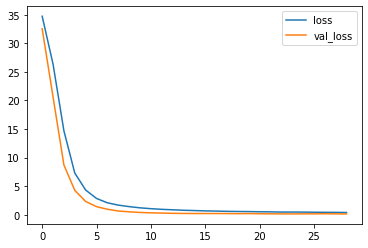

In [71]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();

**the error when the same model was used but this time using the help of time-series analysis**
> *error fall from 6.13 to 1.44 thst is some tremendous change*

# ADDING MORE TIMESERIES

In [ ]:
# def datetime_features(data):
#     data['date'] = pd.to_datetime(data['date'])
#     data['month'] = data.date.dt.month
#     data['day_of_month'] = data.date.dt.day
#     data['day_of_year'] = data.date.dt.dayofyear
#     data['week_of_year'] = data.date.dt.weekofyear
#     data['day_of_week'] = data.date.dt.dayofweek + 1
#     data['year'] = data.date.dt.year
#     data["is_wknd"] = data.date.dt.weekday // 4
#     data["quarter"] = data.date.dt.quarter
#     data['is_month_start'] = data.date.dt.is_month_start.astype(int)
#     data['is_month_end'] = data.date.dt.is_month_end.astype(int)
#     data['is_quarter_start'] = data.date.dt.is_quarter_start.astype(int)
#     data['is_quarter_end'] = data.date.dt.is_quarter_end.astype(int)
#     data['is_year_start'] = data.date.dt.is_year_start.astype(int)
#     data['is_year_end'] = data.date.dt.is_year_end.astype(int)
    
#     week_names = {'Sunday':0,'Monday':1,'Tuesday':2,'Wednesday':3, 'Thursday':4,'Friday':5,'Saturday':6}
#     month_names = {'January':0, 'February':1,'March':2,'April':3,'May':4,'June':5,'July':6,
#                 'August':7, 'September':8,'October':9,'November':10,'December':11}
    
#     return data


# data3 = datetime_features(data2)


In [ ]:
# d3 = data3.loc[: 1000]

In [ ]:
moving_average = temp_df.rolling(
    window=7,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=2,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = temp_df.plot(style=".", color="0.5")
# ax.plotwidth(3)
moving_average.plot(
    ax=ax, linewidth=3, title="Tunnel Traffic - 365-Day Moving Average")#, legend=False,
# );

In [76]:
temp_df.head()

,id,gender,age,number_of_kids,date,online_hours,day_name,day,month,month_name,year,dayofweek,week
0,979863,1,26,2,2017-06-01,8.8,4,1,6,5,2017,3,22
1,979863,1,26,2,2017-06-02,11.7,5,2,6,5,2017,4,22
2,979863,1,26,2,2017-06-03,9.9,6,3,6,5,2017,5,22
3,979863,1,26,2,2017-06-04,9.1,0,4,6,5,2017,6,22
4,979863,1,26,2,2017-06-06,11.1,2,6,6,5,2017,1,23


<AxesSubplot:title={'center':'Seasonal Plot (week/dayofweek)'}, xlabel='dayofweek', ylabel='online_hours'>

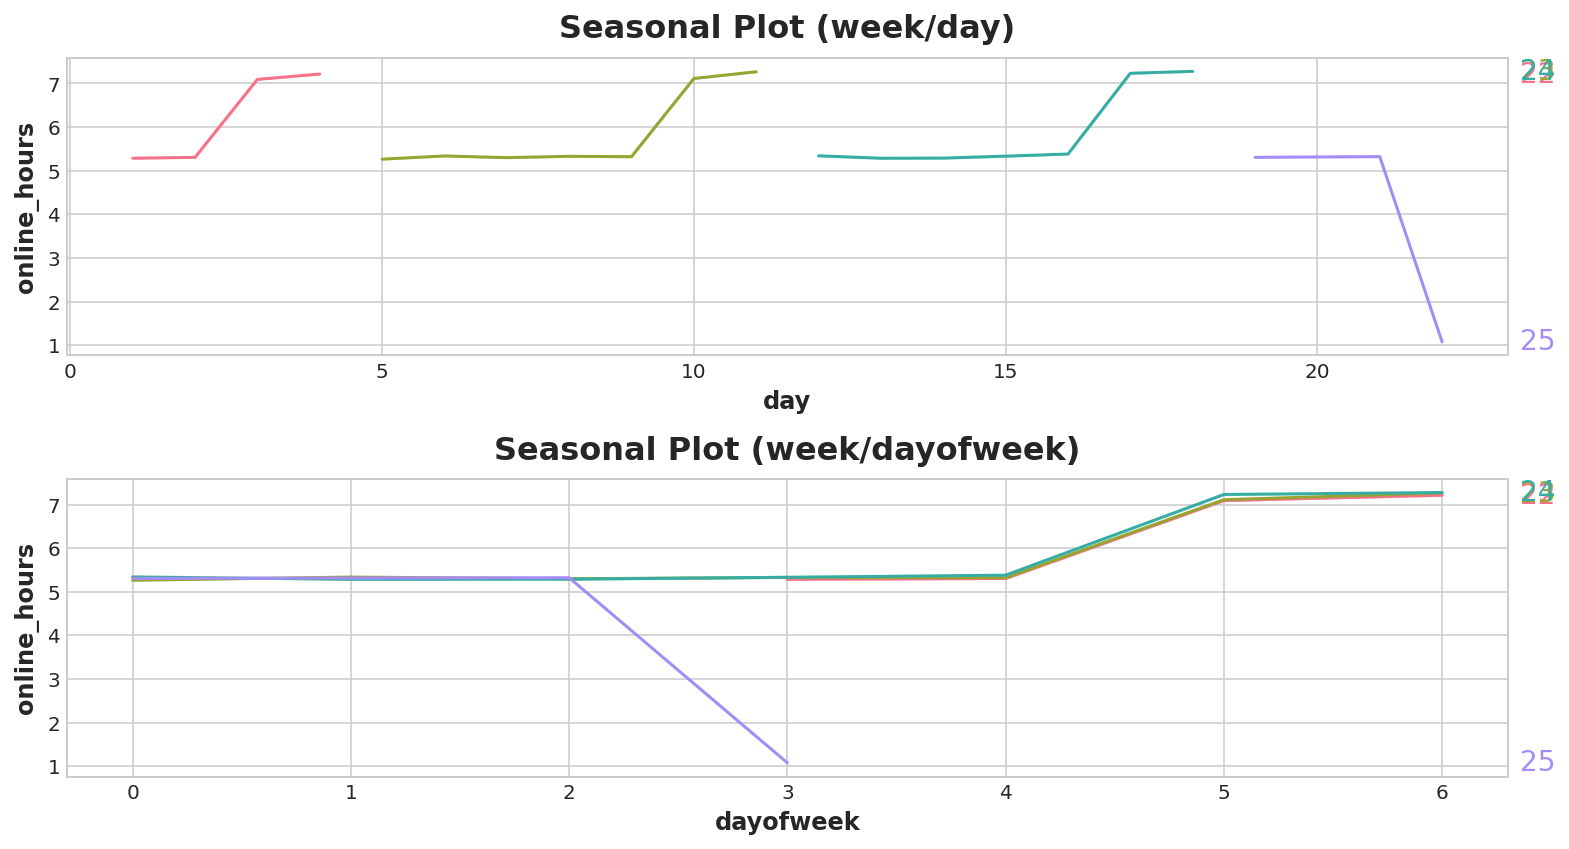

In [77]:
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'


def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
# d3 = data3.copy()

# # days within a week
# d3["day"] = temp_df.index.dayofweek  # the x-axis (freq)
# d3["week"] = temp_df.index.week  # the seasonal period (period)

# days within a year
# d3["dayofyear"] = temp_dftemp_df.index.dayofyear
# d3["year"] =temp_dfd3.index.year
seasonal_plot(temp_df, y="online_hours", period="week", freq="day", ax=ax0)
seasonal_plot(temp_df, y="online_hours", period="week", freq="dayofweek", ax=ax1)

In [ ]:
y = flu_trends.FluVisits.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=60, shuffle=False)

# Fit and predict
model = LinearRegression()  # `fit_intercept=True` since we didn't use DeterministicProcess
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)
ax = y_train.plot(**plot_params)
ax = y_test.plot(**plot_params)
ax = y_pred.plot(ax=ax)
_ = y_fore.plot(ax=ax, color='C3')

In [ ]:


def rolling_window_mean(data):
    # 7 day rolling window mean
    for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,61,17,18,19,20,21]:
        data["onlinehours_roll_mean_"+str(i)] = data.groupby(["id"])['online_hours'].rolling(i).mean().shift(1).values
    #data.fillna(0,inplace = True)
    return data

def lag_features(data,lags = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,61,17,18,19,20,21]):
    data.sort_values(by=['id','date'], axis=0, inplace=True)
    data = data.copy()
    for lag in lags:
        data['last_day_onlinehours'+str(lag)] = data.groupby('id')['online_hours'].transform(lambda x: x.shift(lag))
        data['last_day_hours_diff' +str(lag)] = data.groupby('id')['last_day_onlinehours'+str(lag)].transform(lambda x: x.diff())
        #dataframe.fillna(0,inplace = True)
    return data

def preprocessing_traindata(df):
    data = df.copy()
    data = datetime_features(data)
    data = rolling_window_mean(data)
    data = lag_features(data)
    return data

df_copy  = preprocessing_traindata(df)

train_final = df_copy[df_copy['day_of_month'] < 22]
test_final = df_copy[df_copy['day_of_month'] >= 22]

In [ ]:
# making a lsit ot store cross validate values
kfolds = KFold(n_splits = 5, shuffle = False)

score_list = []
for idx, reg in enumerate(baseline_models):
#     t = time.time()
#     print('Fitting of {} Model'.format(algo[idx]))
#     print('Parameters of the model are: {}'. format(reg.get_params()))
    
    model = reg
    model.fit(X_train,y_train)
    preds = model.predict(X_test)
    r2 = r2_score(y_test,preds)

    print('time elapsed is : {} sec'.format(round((time.time() - t),2)))
    print('\n\n\n*****************************\n\n\n')
    score_list.append(r2)

baseline = pd.DataFrame({'r2_score':score_list,
                      "Algorithm":['LinearRegression','Lasso', 'RandomForestRegressor' ,'AdaBoostRegressor',
                                          'GradientBoostingRegressor', 'XGBRegressor','LGBMRegressor']})
fig,ax = plt.subplots(figsize = (12,5), dpi = 100)
fig.patch.set_facecolor('#f5f6f6')
ax.axes.set_facecolor('#f5f6f6')

ax.tick_params(axis='both', 
                   labelsize = 12, which = 'major',
                   direction = 'out',pad = 2,
                   length = 0.001)

ax.barh(y = baseline['Algorithm'], width = baseline['r2_score'] , height = 0.5, color = colors[1], edgecolor = colors[0], linewidth =2)
ax.set_yticklabels(baseline['Algorithm'], {'font':'serif','size':16,'weight':'bold'}, )


# cheching the RSME score and comparing it with the previous normal regression score

In [ ]:
train = df_copy[df_copy['day_of_month'] < 22]
test = df_copy[df_copy['day_of_month'] >= 22]


xtrain,xtest = train.drop(columns = ['id','date','online_hours']),test.drop(columns = ['id','date','online_hours'])
xtrain = xtrain[feature_import]
xtest = xtest[feature_import]
ytrain,ytest = train['online_hours'].values, test['online_hours'].values
    
model = LGBMRegressor(n_estimators = 1000)
model.fit(xtrain,ytrain)
preds = model.predict(xtest)
    
score = rmse(test_df.online_hours.tolist(),preds)

    
print('\n' +'*'*20  +'Baseline Model RMSE Score with feature selection'+'*'*20 + '\n')
print('                 RMSE Score:    %.5f' % score)
print('\n' +'*'*81 + '\n')

# final prediction model